In [1]:
# Importing libraries
import os, json, time
import prophet
import pandas as pd
from pyproj import Transformer, Geod
import math
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import geojson
import numpy as np
import seaborn as sns
import requests

/home/ghost/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Importing custom libraries
sys.path.append('/home/ghost/Desktop/MSDS/DATA-512/project/data-512-project') 
from wildfire.Reader import Reader as WFReader
  

Attribute:<br>
Code snippet sourced from Dr. David W. McDonald's "wildfire_geo_proximity_example.ipynb" notebook<br>
License: CC BY 4.0<br>
Original Source: https://colab.research.google.com/drive/1qNI6hji8CvDeBsnLDAhJXvaqf2gcg8UV

In [3]:

# Setting up the environment and data paths
EXTRACT_FILENAME = "USGS_Wildland_Fire_Combined_Dataset.json"
MODULENAME = "data/GeoJSON_Exports/"
MODULEPATH = ""
os.environ['PYTHONPATH'] = '/home/ghost/Desktop/MSDS/DATA-512/project/data-512-project'

try:
    ppath = os.environ.get('PYTHONPATH')
    if not ppath: raise
    MODULEPATH = os.path.join(ppath,MODULENAME)
except:
    # Likely here because a PYTHONPATH was not set, show a warning message
    print("Looks like you're not using a 'PYTHONPATH' to specify the location of your python user modules.")
    print("You may have to modify the sample code in this notebook to get the described results.")
    MODULEPATH = ""

if MODULEPATH:
    SAMPLE_DATA_FILENAME = os.path.join(MODULEPATH,EXTRACT_FILENAME)
else:
    SAMPLE_DATA_FILENAME = EXTRACT_FILENAME
print(f"{SAMPLE_DATA_FILENAME=}")

SAMPLE_DATA_FILENAME='/home/ghost/Desktop/MSDS/DATA-512/project/data-512-project/data/GeoJSON_Exports/USGS_Wildland_Fire_Combined_Dataset.json'


In [4]:
# Open the GeoJSON file and load it into a dictionary
print(f"Attempting to open '{SAMPLE_DATA_FILENAME}'")
geojson_file = open(SAMPLE_DATA_FILENAME,"r")
print(f"Using GeoJSON module to load sample file '{SAMPLE_DATA_FILENAME}'")
gj_data = geojson.load(geojson_file)
geojson_file.close()

# Print the keys of the dictionary
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()


Attempting to open '/home/ghost/Desktop/MSDS/DATA-512/project/data/GeoJSON_Exports/USGS_Wildland_Fire_Combined_Dataset.json'
Using GeoJSON module to load sample file '/home/ghost/Desktop/MSDS/DATA-512/project/data/GeoJSON_Exports/USGS_Wildland_Fire_Combined_Dataset.json'
The loaded JSON dictionary has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']



In [ ]:
# Filter the data to only include records from 1963 to 2023
filtered_data = []

all_wildfire=gj_data['features']

for data_point in tqdm(all_wildfire):
    if 1963 <= data_point['attributes']['Fire_Year'] <= 2023:
        filtered_data.append(data_point)

num_records = len(filtered_data)
print(f"Number of records after filtering data for years between 1963 and 2023 and assigned fire type 'Wildfire': {num_records}\n")


In [6]:
# Assigned city coordinates of city: Grand Fork (county: Grand Fork, state: North Dakota)
gf_city = [48.0038,-97.3595]


In [7]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [8]:
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point


In [ ]:
# Filtering fire perimeters within 1250 miles of gf City
gf_wildfire = []

for fire_perimeter in tqdm(filtered_data):
    if 'geometry' in fire_perimeter and 'rings' in fire_perimeter['geometry']:
        closest_point = shortest_distance_from_place_to_fire_perimeter(gf_city, fire_perimeter['geometry']['rings'][0])
        if closest_point[0] <= 1250:
            fire_perimeter['closest_point'] = closest_point[1]
            fire_perimeter['closest_distance'] = closest_point[0]
            gf_wildfire.append(fire_perimeter)
print(len(gf_wildfire))


In [10]:
with open('../data/grand_fork_wildfire.json', 'w') as json_file:
    json.dump(gf_wildfire, json_file)

In [20]:
with open('../data/grand_fork_wildfire.json', 'r') as file:
    gf_wildfire = json.load(file)

# Smoke estimation

In [ ]:
# Define parameters for proximity impact calculation
decay_factor = 0.05  # You can adjust this factor to control the impact decay rate

# Create a dictionary to store the estimated smoke impact for each year
yearly_smoke_impacts = {}
min_smoke_estimate = float('inf')
max_smoke_estimate = -float('inf')

smoke_estimate = []

# Iterate through each fire perimeter in gf_wildfire
for fire_perimeter in tqdm(gf_wildfire):
    # Calculate the distance from the city

    closest_distance = fire_perimeter['closest_distance']

    # Calculate the proximity impact using an exponential decay function
    proximity_impact = math.exp(-decay_factor * closest_distance)

    # You mentioned that you don't want to categorize fire size, so use the original fire size directly
    fire_size = fire_perimeter['attributes']['GIS_Acres']
    fire_perimeter['smoke_estimate'] = proximity_impact * fire_size
    smoke_estimate.append(fire_perimeter)
    
    if min_smoke_estimate > fire_perimeter['smoke_estimate']:
        min_smoke_estimate = fire_perimeter['smoke_estimate']

    if max_smoke_estimate < fire_perimeter['smoke_estimate']:
        max_smoke_estimate = fire_perimeter['smoke_estimate']

    

In [ ]:
import re
import datetime
from tqdm import tqdm

# Initialize the dictionary to store smoke impacts by year
yearly_smoke_impacts = {}

# Create an empty list to store normalized smoke estimates with additional data
norm_smk_estmte = []
no_data_count = 0

# Assuming 'smoke_estimate' is a list of dictionaries with 'smoke_estimate' and 'attributes' keys
for fire_perimeter in tqdm(smoke_estimate):
    # Calculate the normalized smoke estimate
    cur_smoke_estimate = fire_perimeter['smoke_estimate']
    normalized_smoke_estimate = ((cur_smoke_estimate - min_smoke_estimate) /
                                 (max_smoke_estimate - min_smoke_estimate)) * 500
    fire_perimeter['normalized_smoke_estimate'] = normalized_smoke_estimate
    
    # Extract fire year and listed fire dates if available
    attributes = fire_perimeter.get('attributes', {})
    fire_year = attributes.get('Fire_Year')
    listed_fire_dates = attributes.get('Listed_Fire_Dates')

    # Proceed only if 'listed_fire_dates' is a string
    if not isinstance(listed_fire_dates, str):
        print(f"'Listed_Fire_Dates' is not a string: {listed_fire_dates}")
        continue  # Skip to the next iteration

    # Find all dates matching the pattern in 'listed_fire_dates'
    fire_dates = re.findall(r"(\d{4}-\d{2}-\d{2})", listed_fire_dates)
    
    # Proceed only if there are any dates found
    if not fire_dates:
        print(f"No dates found in 'Listed_Fire_Dates': {listed_fire_dates}")
        no_data_count += 1
        continue

    # The first date is the start date and the last is the end date
    fire_start_date_str, fire_end_date_str = fire_dates[0], fire_dates[-1]
    
    # Parse the string dates into datetime objects
    fire_start_date = datetime.datetime.strptime(fire_start_date_str, '%Y-%m-%d').date()
    fire_end_date = datetime.datetime.strptime(fire_end_date_str, '%Y-%m-%d').date()

    # Define fire season start and end dates for the respective years
    fire_season_start = datetime.date(fire_year, 5, 1) if fire_year else None
    fire_season_end = datetime.date(fire_year, 10, 31) if fire_year else None

    # Ensure that we have fire season dates and a valid fire year to compare
    if fire_year and fire_season_start and fire_season_end:
        # Check if the fire is within the fire season
        if (fire_start_date <= fire_season_end) and (fire_end_date >= fire_season_start):
            # Add or update the smoke impact for the fire year
            yearly_smoke_impacts[fire_year] = yearly_smoke_impacts.get(fire_year, 0) + normalized_smoke_estimate

    # Add updated perimeter data to the list
    norm_smk_estmte.append(fire_perimeter)


In [12]:
# Dump the updated data to a JSON file - part 2
with open('../data/normalized_smoke_estimate.json', 'w') as json_file:
    json.dump(norm_smk_estmte, json_file)

# Getting AQI Info: API key and data

In [13]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response




In [14]:
#print("Requesting SIGNUP ...")
response = request_signup("harshit@uw.edu")
print(json.dumps(response,indent=4))

{
    "Header": [
        {
            "status": "Success",
            "request_time": "2023-11-08T20:54:18-05:00",
            "url": "https://aqs.epa.gov/data/api/signup?email=harshit@uw.edu"
        }
    ],
    "Data": [
        "You should receive a registration confirmation email with a link for confirming your email shortly."
    ]
}


In [18]:
#
#   Once we have the signup email, we can define two constants
#   USERNAME - This should be the email address you sent the EPA asking for access to the API during sign-up
#   APIKEY   - This should be the authorization key they sent you
#
#   In this case I don't want to distribute my keys with the source of the notebook, so I wrote a key manager object that
#   helps track all of my API keys - a username and domain name retrieves the key. The key manager hides the keys on disk
#   separate from the code. Often you see code that assumes you have stored your API key as an OS environment variable.
#
# from apikeys.Manager import Manager
# keyman = Manager()

# USERNAME = "dwmc@uw.edu"
# key_info = keyman.findRecord(USERNAME,API_REQUEST_URL)
# APIKEY = key_info[0]['key']
# print(key_info[0]['description'])
#print(APIKEY)
#
#   You can specify these as constants for your own use - just don't distribute the notebook without removing the constants
#
USERNAME = "harshit@uw.edu"
APIKEY = "silverswift25"


In [19]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [ ]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


In [22]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [ ]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


In [24]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

In [25]:
#
#   We'll use the city location in the examples below.
#
CITY_LOCATIONS = {
    'Grand Fork' :          {'city'   : 'Grand Fork',
                       'county' : 'Grand Fork',
                       'state'  : 'North Dakota',
                       'fips'   : '38035',
                       'latlon' : [48.0038,-97.3595]}
}


In [ ]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['Grand Fork']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['Grand Fork']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


In [28]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [29]:

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['Grand Fork']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['Grand Fork']['fips'][2:]

In [30]:
#
#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result


In [ ]:
# Request daily summary data for the 1963-2023
average_aqi_per_year = {}
for year in tqdm(range(1963, 2023)):
    
    year_aqi_count = 0
    year_aqi_sum = 0
    count = 0
    begin_date = f"{year}0101"
    end_date = f"{year}1231"
    request_data['param'] = AQI_PARAMS_PARTICULATES
    # request daily summary data for the month of July in 2021
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=begin_date, end_date=end_date)
    try:       
        if particulate_aqi["Header"][0]['status'].startswith("No data "):
            print(f"No data for year {begin_date}-{end_date}.")
        extract_particulate = extract_summary_from_response(particulate_aqi)
        first_site_location = next(iter(extract_particulate.values()))
        data_for_first_site = first_site_location.get('pollutant_type', {})
        for pollutant_data in data_for_first_site.values():
            year_aqi_data = pollutant_data.get('data', {})
            # Loop through the data for each date in the year
            for date, aqi_list in year_aqi_data.items():
                for entry in aqi_list:
                    if entry['aqi']:
                        year_aqi_sum += entry['aqi']
                        year_aqi_count += 1
    except Exception as e:
        pass
    # Calculate the average AQI for the year
    if year_aqi_count > 0:
        average_aqi = year_aqi_sum / year_aqi_count
        average_aqi_per_year[year] = average_aqi

In [50]:
with open('../data/aqi_by_year.json', 'w') as f:
    json.dump(average_aqi_per_year, f, indent=4)

In [51]:
with open('../data/yearly_smoke_impacts.json', 'w') as f:
    json.dump(yearly_smoke_impacts, f, indent=4)

In [5]:
with open('../data/aqi_by_year.json', 'r') as file:
    average_aqi_per_year = json.load(file)
with open('../data/yearly_smoke_impacts.json', 'r') as file:
    yearly_smoke_impacts = json.load(file)

In [6]:
# Min-max scaling function
def min_max_scale(values_list):
    min_val = min(values_list)
    max_val = max(values_list)
    scaled_values_list = [(value - min_val) / (max_val - min_val) for value in values_list]
    return scaled_values_list

Correlation Coefficient: -0.7388035143860711


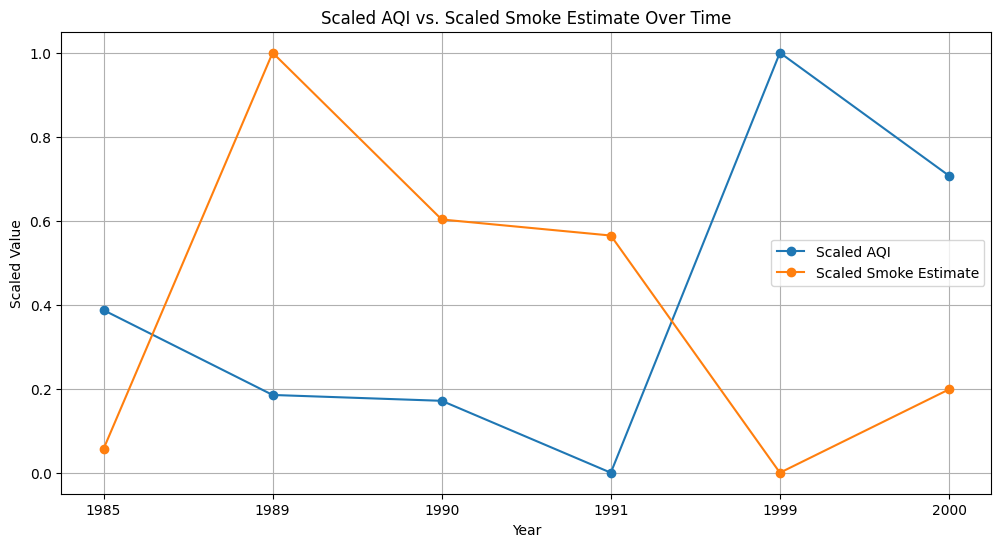

In [24]:
# Your AQI data
aqi_data = average_aqi_per_year

# Use the updated smoke estimate data for further calculations

# Filter the dictionaries
filtered_yearly_smoke_impacts = {year: impact for year, impact in yearly_smoke_impacts.items() if impact >= 20}
filtered_yearly_aqi_impacts = {year: aqi for year, aqi in aqi_data.items() if aqi >= 0}

# Find the common years
years = sorted(set(filtered_yearly_aqi_impacts.keys()).intersection(filtered_yearly_smoke_impacts.keys()))

# Extract values for common years
aqi_values = [filtered_yearly_aqi_impacts[year] for year in years]
smoke_estimate_values = [filtered_yearly_smoke_impacts[year] for year in years]

# Apply min-max scaling to both datasets
scaled_aqi_values = min_max_scale(aqi_values)
scaled_smoke_estimate_values = min_max_scale(smoke_estimate_values) 

# Calculate the correlation coefficient
correlation = np.corrcoef(scaled_aqi_values, scaled_smoke_estimate_values)[0, 1]

# Print the correlation coefficient
print(f"Correlation Coefficient: {correlation}")

# Create a line chart to visualize the data
plt.figure(figsize=(12, 6))
plt.plot(years, scaled_aqi_values, label='Scaled AQI', marker='o', linestyle='-')
plt.plot(years, scaled_smoke_estimate_values, label='Scaled Smoke Estimate', marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Scaled Value')
plt.title('Scaled AQI vs. Scaled Smoke Estimate Over Time')
plt.legend()
plt.grid(True)
plt.show()

The correlation coefficient of -0.7388035143860711 indicates a moderate to strong negative correlation between the two variables being analyzed. The correlation coefficient is a statistical measure that quantifies the strength and direction of a relationship between two variables. In this case, the coefficient value being closer to -1 suggests that as one variable increases, the other variable tends to decrease with a relatively strong linear relationship.

It's important to note that a correlation coefficient closer to 1 implies a strong positive correlation, suggesting that both variables increase together. Conversely, a value closer to -1 implies a strong negative correlation, indicating that one variable tends to decrease as the other increases. A value of 0 would indicate no correlation.

Given the coefficient value of -0.7388035143860711, it suggests that there is a noteworthy negative trend between the variables, implying that they move in opposite directions to a considerable extent. This negative correlation is significant enough to suggest that the variables are inversely related to each other in a way that is more than just by chance.

### Forecasting Smoke Levels Over 25 Years
This part of the study uses an advanced forecasting technique to guess how much smoke Grand Fork county will have over the next quarter-century. We take old records of smoke levels and use them to estimate future amounts.

#### Getting Data Ready
We put past smoke data into a structured table using two common data-handling tools, NumPy and Pandas. The column with years is changed into dates so we can analyze it properly.

#### Using Prophet for Forecasting
We set up the Prophet tool to consider weekly changes. It looks at the old data to pick up on regular patterns and shifts in smoke levels.

#### Making Future Forecasts
We make a new table that will show our smoke predictions for 25 years into the future. Using Prophet, we calculate what the smoke levels might be in the coming years.

#### Drawing the Predictions
We make a chart of the predicted smoke levels to show what might happen with smoke in Grand Fork county. This chart helps us see what the future trends and shifts in smoke levels could be.

22:23:57 - cmdstanpy - INFO - Chain [1] start processing


22:23:57 - cmdstanpy - INFO - Chain [1] done processing


           ds        yhat  yhat_lower  yhat_upper
58 2020-12-31   93.671061    1.295831  181.443025
59 2021-12-31  101.659096   -2.983465  191.873709
60 2022-12-31  135.428205   46.045573  230.360103
61 2023-12-31  165.823073   70.690771  262.674845
62 2024-12-31  147.412932   48.655282  246.886823
63 2025-12-31  116.226469   22.939246  209.729326
64 2026-12-31  112.811165   20.987850  205.025369
65 2027-12-31  120.016025   29.350324  217.905349
66 2028-12-31  165.883386   80.322448  256.174263
67 2029-12-31  163.672422   70.403755  260.340302
68 2030-12-31  166.553037   77.867322  259.175749
69 2031-12-31  134.583399   46.859304  238.220899
70 2032-12-31  120.076338   14.999605  210.525862
71 2033-12-31  154.235284   67.182020  256.324550
72 2034-12-31  185.023491   92.034111  277.013934
73 2035-12-31  182.029351   87.211903  277.693915
74 2036-12-31  134.643712   41.934644  225.373281
75 2037-12-31  131.618245   33.106780  221.115195
76 2038-12-31  139.216443   39.177012  234.484546


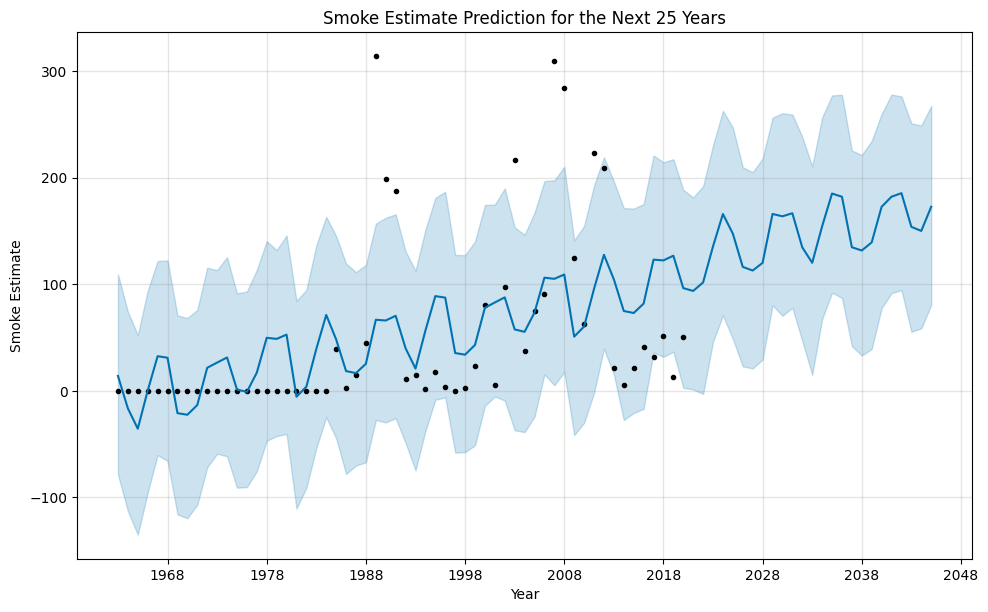

In [21]:
# Sample data for the model
years = np.array(list(yearly_smoke_impacts.keys())).reshape(-1, 1)
smoke_estimate = np.array(list(yearly_smoke_impacts.values()))


# Create a pandas DataFrame with the provided data
df = pd.DataFrame(list(yearly_smoke_impacts.items()), columns=['ds', 'y'])

# Convert the 'ds' column to datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y')

# Fit the Prophet model
model = prophet.Prophet(weekly_seasonality=True)
model.fit(df)

# Create a future DataFrame for predictions
future = model.make_future_dataframe(periods=25, freq='Y')

# Make predictions
forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(25))

# Plot the forecast
fig = model.plot(forecast)
plt.title('Smoke Estimate Prediction for the Next 25 Years')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.show()

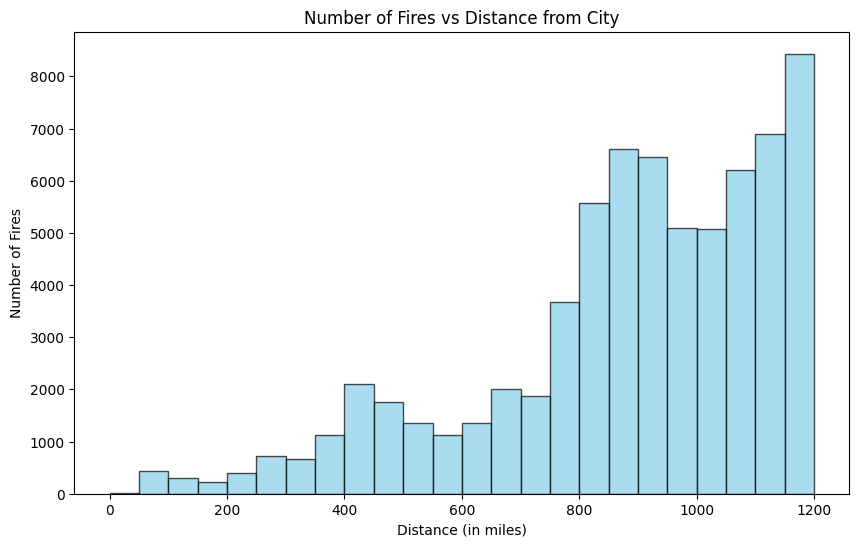

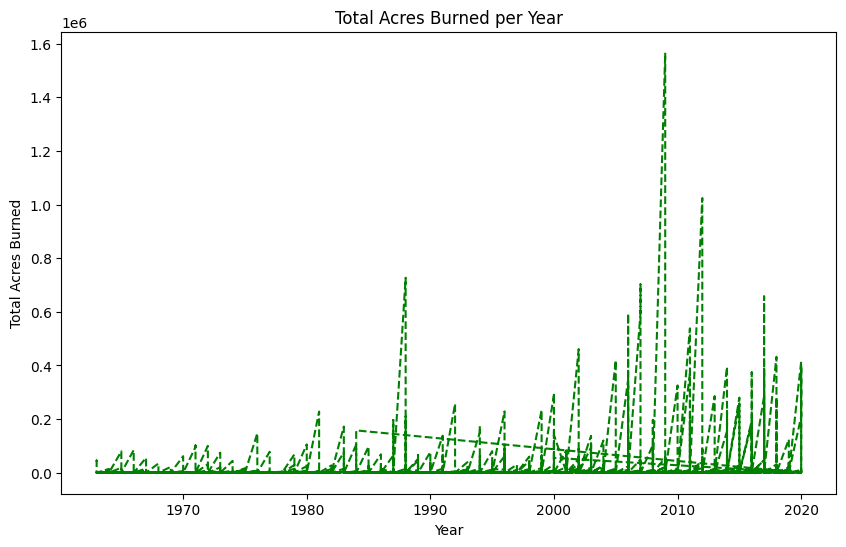

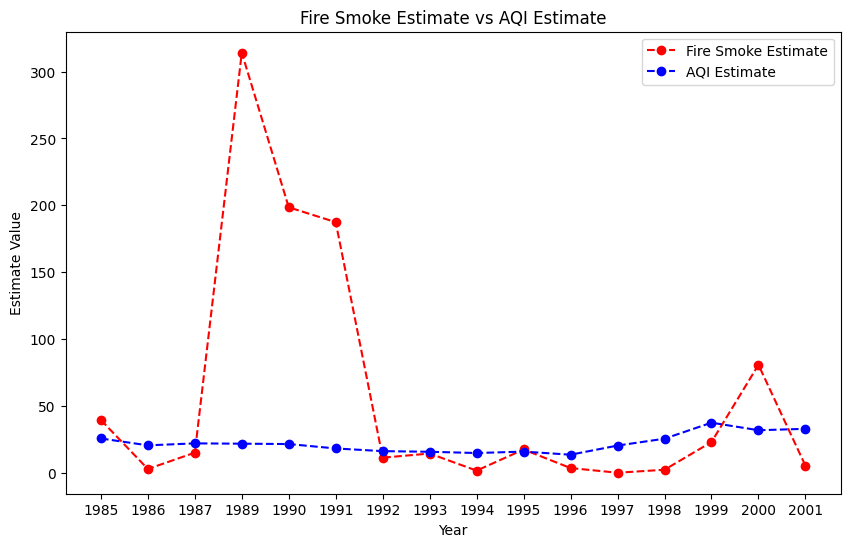

In [22]:
# Histogram showing the number of fires every 50 miles from the city
distances = [fire['closest_distance'] for fire in gf_wildfire]
max_distance = int(max(distances))
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=range(0, max_distance, 50), edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Number of Fires vs Distance from City')
plt.xlabel('Distance (in miles)')
plt.ylabel('Number of Fires')
plt.show()

# Time series graph of total acres burned per year for fires near the city (1250 miles)
years = [fire['attributes']['Fire_Year'] for fire in gf_wildfire]
acres_burned = [fire['attributes']['GIS_Acres'] for fire in gf_wildfire]
plt.figure(figsize=(10, 6))
plt.plot(years, acres_burned, linestyle='--', color='green')
plt.title('Total Acres Burned per Year')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.show()

# Time series graph of fire smoke estimate and AQI estimate for the city
# Find common years between the two datasets
common_years = sorted(set(yearly_smoke_impacts.keys()).intersection(average_aqi_per_year.keys()))

# Filter out the data for only the common years
fire_smoke_estimate = [yearly_smoke_impacts[year] for year in common_years]
aqi_estimate = [average_aqi_per_year[year] for year in common_years]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(common_years, fire_smoke_estimate, marker='o', linestyle='--', color='red', label='Fire Smoke Estimate')
plt.plot(common_years, aqi_estimate, marker='o', linestyle='--', color='blue', label='AQI Estimate')
plt.title('Fire Smoke Estimate vs AQI Estimate')
plt.xlabel('Year')
plt.ylabel('Estimate Value')
plt.legend()
plt.show()